In [1]:
!pip install torchdiffeq

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from tqdm.notebook import tqdm
import time

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from torchdiffeq import odeint_adjoint

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(str(device) + ' is being used...')

cuda is being used...


Solvers

In [ ]:
def euler(func, t, dt, y):
  return dt * func(t, y)

In [ ]:
def rk4(func, t, dt, y):
  one_sixth = 1/6
  half_dt = dt * 0.5

  k1 = func(t, y)
  k2 = func(t + half_dt, y + half_dt * k1)
  k3 = func(t + half_dt, y + half_dt * k2)
  k4 = func(t + dt, y + dt * k3)

  return (k1 + 2 * (k2 + k3) + k4) * dt * one_sixth

In [ ]:
class NeuralODE(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, y0, t, solver):
    solution = torch.empty(len(t), *y0.shape, dtype=y0.dtype, device=y0.device)
    solution[0] = y0

    j = 1
    for t0, t1 in zip(t[:-2], t[1:]):
      dy = solver(self.func, t0, t1 - t0, y0)
      y1 = y0 + dy
      solution[j] = y1
      j += 1
      y0 = y1
    return solution

ODE Models

In [ ]:
class ODEFuncTanh(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(1, 10),
                             nn.Tanh(),
                             nn.Linear(10, 10),
                             nn.Tanh(),
                             nn.Linear(10, 1))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

In [ ]:
class ODEFuncSig(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2, 50),
                             nn.Sigmoid(),
                             nn.Linear(50, 2))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

In [ ]:
class ODEFuncReLU(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2, 50),
                             nn.ReLU(),
                             nn.Linear(50, 50),
                             nn.ReLU(),
                             nn.Linear(50, 2))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

In [ ]:
class SinAct(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class ODEFuncSinAct(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2, 50),
                             SinAct(),
                             nn.Linear(50, 2))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

Spring Mass Function<br><br>
F = -kx <br>

In [ ]:
F = 90 # (40√5 ~ 89.4)
mass = 2.0
x = 5.0
k = 2.0
v = 0.0

In [ ]:
# Computing True Value
data_size = 5000
tensor1 = torch.tensor([[x, v]]).cuda()
t = torch.linspace(0., 100., data_size).cuda()
tensor2 = torch.tensor([[0.0, 1.0], [-k/mass, 0.0]]).cuda()
tensor2 = tensor2.transpose(0, 1)
print(tensor2)
print(tensor1.shape, tensor2.shape)

class Lambda(nn.Module):
  def forward(self, t, y):
    return torch.mm(y, tensor2)

with torch.no_grad():
  true_y = odeint_adjoint(func = Lambda(), y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
  print(true_y)

tensor([[ 0., -1.],
        [ 1.,  0.]], device='cuda:0')
torch.Size([1, 2]) torch.Size([2, 2])
tensor([[[ 5.0000,  0.0000]],

        [[ 4.9990, -0.1000]],

        [[ 4.9960, -0.2000]],

        ...,

        [[ 4.2069,  2.7022]],

        [[ 4.2601,  2.6175]],

        [[ 4.3116,  2.5318]]], device='cuda:0')


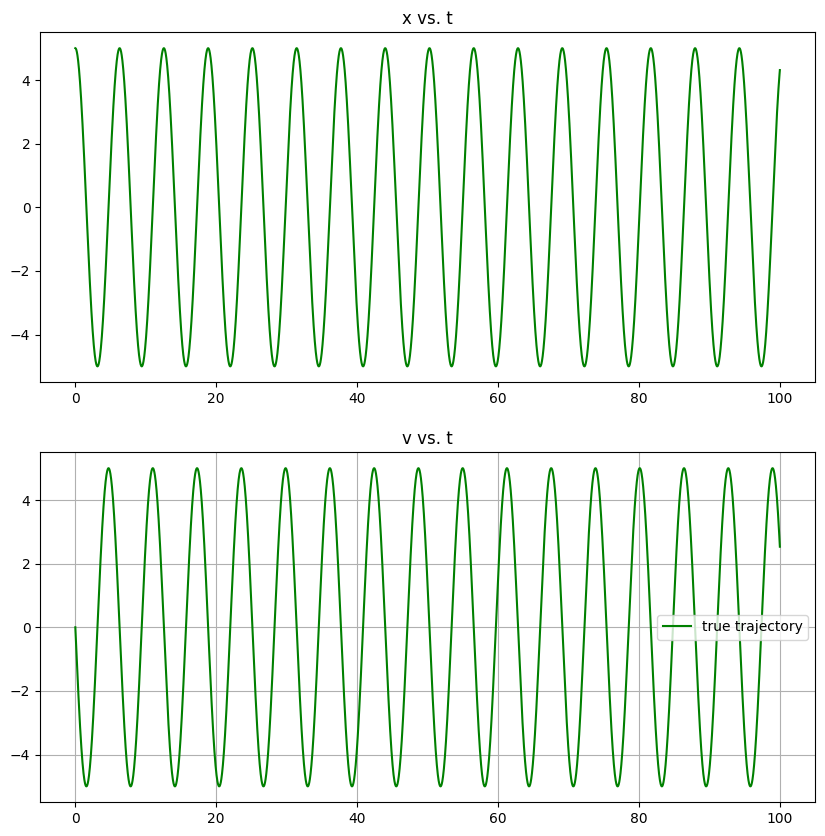

In [ ]:
# Visualizing
def visualize(true_y, pred_y=None):

  fig = plt.figure(figsize = (10, 10))
  ax1 = fig.add_subplot(2, 1, 1)
  ax1.set_title('x vs. t')
  ax1.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], 'green', label='true trajectory')

  ax2 = fig.add_subplot(2, 1, 2)
  ax2.set_title('v vs. t')
  ax2.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'green', label='true trajectory')

  if pred_y is not None:
    ax1.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], 'red', label='prediction')
    ax2.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'red', label='prediction')

  # ax.set_xlim(-5.5, 5.5)
  # ax.set_ylim(-5.5, 5.5)
  plt.legend()
  plt.grid(True)
  plt.show()

visualize(true_y)

In [ ]:
batch_time = 10
batch_size = 16

def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = true_y[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
  return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

In [ ]:
from torchdiffeq import odeint_adjoint

niters = 400

func = ODEFuncSinAct().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
end_time = time.time()
time_required = end_time - start_time
print('Process Time: {} secs'.format(time_required))

  0%|          | 0/401 [00:00<?, ?it/s]

Iter 0400 | Total Loss 0.001819
Process Time: 81.19480180740356 secs


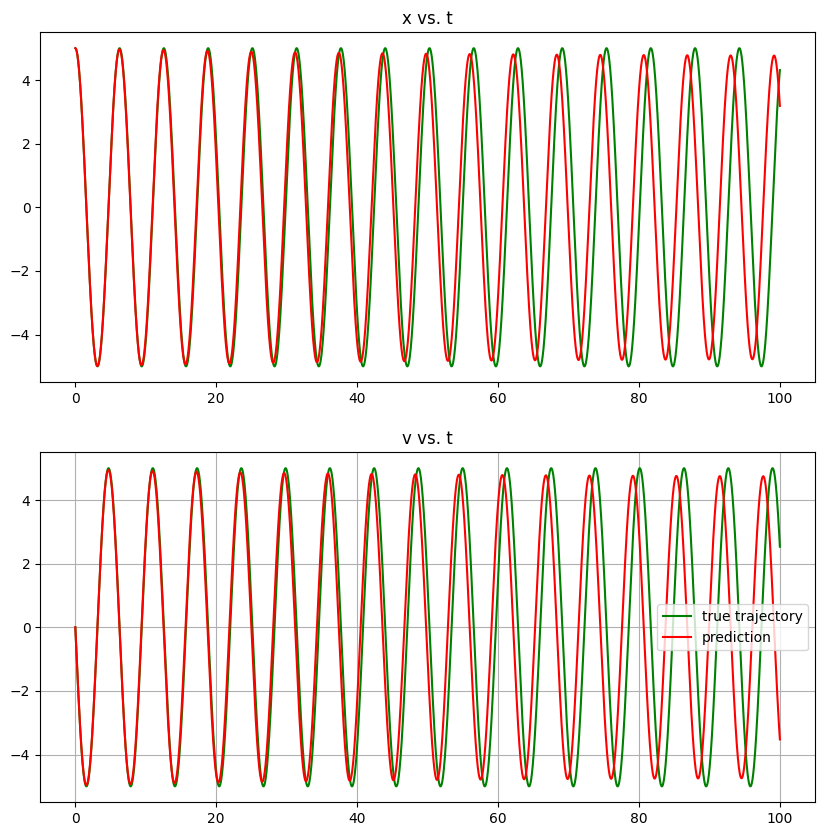

In [ ]:
# Visualing the Predictions
with torch.no_grad():
    pred_y = odeint_adjoint(func = func, y0=tensor1, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
    visualize(true_y, pred_y)

Cos Function

In [ ]:
y0 = torch.Tensor([[0]]).cuda()
t = torch.linspace(0., 6*np.pi, 1500).cuda()

class cos(nn.Module):
  def forward(self, t, y):
    return torch.cos(t) * torch.exp(-0.05*t) + torch.tensor(1)

true_y = odeint_adjoint(func = cos(), y0=y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')

# ***** Visualing *****
def visualize(true_y, pred_y=None):
  fig = plt.figure(figsize = (10, 10))
  ax1 = fig.add_subplot(2, 1, 1)
  ax1.set_title('x vs. t')
  ax1.plot(t.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 0], 'green', label='true trajectory')

  if pred_y is not None:
    print(t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0])
    print(t.cpu().numpy().shape, pred_y.cpu().detach().numpy()[:, 0].shape)
    ax1.plot(t.cpu().numpy(), pred_y.cpu().detach().numpy()[:100, 0], 'red', label='prediction')

  plt.legend()
  plt.grid(True)
  plt.show()

# ***** Training *****
data_size = 1510
batch_time = 100
batch_size = 16

def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = true_y[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
  return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

niters = 500

func = ODEFuncTanh().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()
  if iter%20 == 0:
    print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
    print(pred_y)
    visualize(true_y, pred_y)

# Transposing the result
#test_result = test_result.transpose(0, 1)

with torch.no_grad():
    pred_y = odeint_adjoint(func = func, y0=y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
    visualize(true_y, pred_y)

print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))

In [ ]:
with torch.no_grad():
    pred_y = odeint_adjoint(func = func, y0=y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
    visualize(true_y, pred_y)

A Ball falling towards the ground due to Gravitational Force

In [54]:
%%writefile parsing.py
#!/usr/bin/env python3
import argparse
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchdiffeq import odeint, odeint_adjoint
from torchdiffeq import odeint_event

torch.set_default_dtype(torch.float64)


class BouncingBallExample(nn.Module):
    def __init__(self, radius=0.2, gravity=9.8, adjoint=False):
        super().__init__()
        self.gravity = nn.Parameter(torch.as_tensor([gravity]))
        self.log_radius = nn.Parameter(torch.log(torch.as_tensor([radius])))
        self.t0 = nn.Parameter(torch.tensor([0.0]))
        self.init_pos = nn.Parameter(torch.tensor([10.0]))
        self.init_vel = nn.Parameter(torch.tensor([0.0]))
        self.absorption = nn.Parameter(torch.tensor([0.2]))
        self.odeint = odeint_adjoint if adjoint else odeint

    def forward(self, t, state):
        pos, vel, log_radius = state
        dpos = vel
        dvel = -self.gravity
        return dpos, dvel, torch.zeros_like(log_radius)

    def event_fn(self, t, state):
        # positive if ball in mid-air, negative if ball within ground.
        pos, _, log_radius = state
        return pos - torch.exp(log_radius)

    def get_initial_state(self):
        state = (self.init_pos, self.init_vel, self.log_radius)
        return self.t0, state

    def state_update(self, state):
        """Updates state based on an event (collision)."""
        pos, vel, log_radius = state
        pos = (
            pos + 1e-7
        )  # need to add a small eps so as not to trigger the event function immediately.
        vel = -vel * (1 - self.absorption)
        return (pos, vel, log_radius)

    def get_collision_times(self, nbounces=1):

        event_times = []

        t0, state = self.get_initial_state()

        for i in range(nbounces):
            event_t, solution = odeint_event(
                self,
                state,
                t0,
                event_fn=self.event_fn,
                reverse_time=False,
                atol=1e-8,
                rtol=1e-8,
                odeint_interface=self.odeint,
            )
            event_times.append(event_t)

            state = self.state_update(tuple(s[-1] for s in solution))
            t0 = event_t

        return event_times

    def simulate(self, nbounces=1):
        event_times = self.get_collision_times(nbounces)

        # get dense path
        t0, state = self.get_initial_state()
        trajectory = [state[0][None]]
        velocity = [state[1][None]]
        times = [t0.reshape(-1)]
        for event_t in event_times:
            tt = torch.linspace(
                float(t0), float(event_t), int((float(event_t) - float(t0)) * 50)
            )[1:-1]
            tt = torch.cat([t0.reshape(-1), tt, event_t.reshape(-1)])
            solution = odeint(self, state, tt, atol=1e-8, rtol=1e-8)

            trajectory.append(solution[0][1:])
            velocity.append(solution[1][1:])
            times.append(tt[1:])

            state = self.state_update(tuple(s[-1] for s in solution))
            t0 = event_t

        return (
            torch.cat(times),
            torch.cat(trajectory, dim=0).reshape(-1),
            torch.cat(velocity, dim=0).reshape(-1),
            event_times,
        )


def gradcheck(nbounces):

    system = BouncingBallExample()

    variables = {
        "init_pos": system.init_pos,
        "init_vel": system.init_vel,
        "t0": system.t0,
        "gravity": system.gravity,
        "log_radius": system.log_radius,
    }

    event_t = system.get_collision_times(nbounces)[-1]
    event_t.backward()

    analytical_grads = {}
    for name, p in system.named_parameters():
        for var in variables.keys():
            if var in name:
                analytical_grads[var] = p.grad

    eps = 1e-3

    fd_grads = {}

    for var, param in variables.items():
        orig = param.data
        param.data = orig - eps
        f_meps = system.get_collision_times(nbounces)[-1]
        param.data = orig + eps
        f_peps = system.get_collision_times(nbounces)[-1]
        param.data = orig
        fd = (f_peps - f_meps) / (2 * eps)
        fd_grads[var] = fd

    success = True
    for var in variables.keys():
        analytical = analytical_grads[var]
        fd = fd_grads[var]
        if torch.norm(analytical - fd) > 1e-4:
            success = False
            print(
                f"Got analytical grad {analytical.item()} for {var} param but finite difference is {fd.item()}"
            )

    if not success:
        raise Exception("Gradient check failed.")

    print("Gradient check passed.")


if __name__ == "__main__":

    parser = argparse.ArgumentParser(description="Process some integers.")
    parser.add_argument("nbounces", type=int, nargs="?", default=10)
    parser.add_argument("--adjoint", action="store_true")
    args = parser.parse_args()

    gradcheck(args.nbounces)

    system = BouncingBallExample()
    times, trajectory, velocity, event_times = system.simulate(nbounces=args.nbounces)
    times = times.detach().cpu().numpy()
    trajectory = trajectory.detach().cpu().numpy()
    velocity = velocity.detach().cpu().numpy()
    event_times = torch.stack(event_times).detach().cpu().numpy()

    plt.figure(figsize=(7, 3.5))

    # Event locations.
    for event_t in event_times:
        plt.plot(
            event_t,
            0.0,
            color="C0",
            marker="o",
            markersize=7,
            fillstyle="none",
            linestyle="",
        )

    (vel,) = plt.plot(
        times, velocity, color="C1", alpha=0.7, linestyle="--", linewidth=2.0
    )
    (pos,) = plt.plot(times, trajectory, color="C0", linewidth=2.0)

    plt.hlines(0, 0, 100)
    plt.xlim([times[0], times[-1]])
    plt.ylim([velocity.min() - 0.02, velocity.max() + 0.02])
    plt.ylabel("Markov State", fontsize=16)
    plt.xlabel("Time", fontsize=13)
    plt.legend([pos, vel], ["Position", "Velocity"], fontsize=16)

    plt.gca().xaxis.set_tick_params(
        direction="in", which="both"
    )  # The bottom will maintain the default of 'out'
    plt.gca().yaxis.set_tick_params(
        direction="in", which="both"
    )  # The bottom will maintain the default of 'out'

    # Hide the right and top spines
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)

    # Only show ticks on the left and bottom spines
    plt.gca().yaxis.set_ticks_position("left")
    plt.gca().xaxis.set_ticks_position("bottom")

    plt.tight_layout()
    plt.savefig("bouncing_ball.png")
    plt.show()

Overwriting parsing.py


In [55]:
!python3 parsing.py 4 --adjoint
# Check the Visualization in the png file 'bouncing_ball.png'

Gradient check passed.
Figure(700x350)
